# Experiments 1

In this notebook, we'll split test and train dataset and only consider train set for modeling, outliers deletion, nan deletion etc. 
This is the conventionnal "clean" approach.

In [67]:
!pip install lightgbm

In [85]:
from typing import List, Dict
from configparser import ConfigParser
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, KBinsDiscretizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from src.load_dataset import Loader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline 


## Preparing data set

So that our methods work well, we have to make the assumption that the distributions of train and test set are equal. We shuffle the dataset for that.

In [2]:
loader = Loader()

X_train, y_train = loader.get_train()
X_test, y_test = loader.get_test()

X_train_without_nan, y_train_without_nan = loader.get_train(keep_nan=False)
X_test_without_nan, y_test_without_nan = loader.get_test(keep_nan=False)

In [80]:
# Scoring function
f1 = make_scorer(
    f1_score,
    greater_is_better=True,

)

# fit and test
def fit_and_test_grid(base_pipe: Pipeline, param_grid: List[Dict[str, list]], keep_nan: bool = True, verbose: int = 0):
    if not keep_nan:
        # without nan values
        X_train_, y_train_ = X_train_without_nan, y_train_without_nan
    else:
        # with nan values
        X_train_, y_train_ = X_train, y_train

    grid = GridSearchCV(base_pipe, param_grid, cv=5, verbose=verbose, scoring=f1)

    grid.fit(X_train_, y_train_)
    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)

    print_scores(y_pred)

    print("Best parameters: ", grid.best_estimator_)

    show_confusion_matrix(best_estimator, y_pred)

    if (len(grid.param_grid) > 1):
        plot_grid_search(grid)

    return grid

def plot_grid_search(grid):

    ## Results from grid search
    results = grid.cv_results_
    params = grid.param_grid
    assert len(params) > 1

    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    masks = []
    masks_names = []

    for p_k, p_v in grid.best_params_.items():
        # None parameters aren't working
        if p_v is not None:
            masks.append(list(results['param_'+ p_k].data == p_v))
            masks_names.append(p_k)
        else:
            print(p_k)
            masks.append(list(results['param_'+ p_k].data == p_v))
            masks_names.append(p_k)

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

def show_confusion_matrix(estimator, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=estimator.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=estimator.classes_)
    disp.plot()
    plt.show()

def print_scores(y_pred):
    print("Precision: ", round(precision_score(y_test, y_pred), 2))
    print("Recall: ", round(recall_score(y_test, y_pred), 2))
    print("F1-score: ", round(f1_score(y_test, y_pred), 2))


# Methodology


## Dealing with NaN values


We'll first train our models by dropping the missiong values in train set, then we'll try different techniques to impute train data. However, missing values can't be simply dropped from test set to evaluate the models.
In fact, by doing so, we would artificially increase the our results. Either we replace these dropped lines by false predictions or we train an imputer on train set to fill the missing values. We chose to use imputers.



# Dummy classifier

DummyClassifier is a classifier that makes predictions using simple rules.
This classifier is useful as a simple baseline to compare with other (real) classifiers.

Precision:  0.42
Recall:  0.51
F1-score:  0.46
Best parameters:  Pipeline(steps=[('classifier', DummyClassifier(strategy='uniform'))])


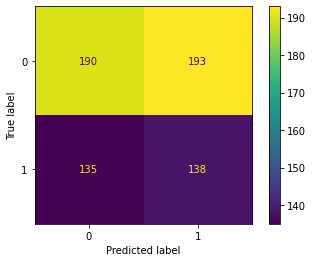

In [95]:
DUMMY_PARAMS = {
    'classifier__strategy': ["stratified", "most_frequent", "prior", "uniform"]
}

dummay_pipe = Pipeline([
    ("classifier", DummyClassifier())
])

dummy_grid = fit_and_test_grid(dummay_pipe, DUMMY_PARAMS, keep_nan=True, verbose=0)

We know that a dummy classifier can obtain a **F1-score of 0.48**. It will be used as a reference.

# Decision tree

We'll start with a decision tree. Our intuition tells us that the potability of water should follow some rules (ex: pH in [6.5, 8.5]).

Precision:  0.52
Recall:  0.36
F1-score:  0.43
Best parameters:  Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier',
                 DecisionTreeClassifier(max_depth=18, max_features='auto',
                                        min_samples_leaf=24,
                                        random_state=12))])


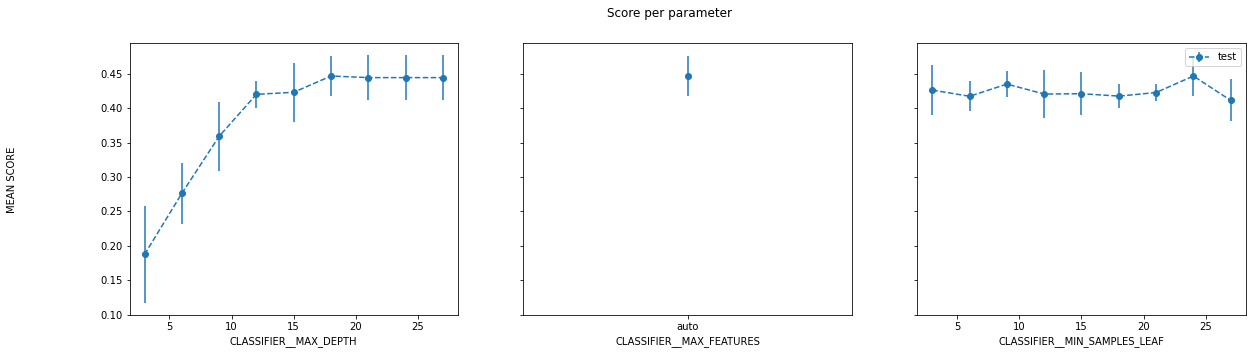

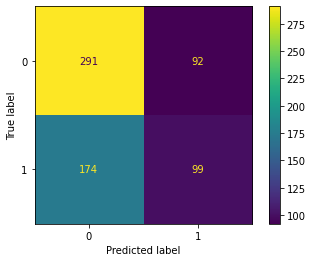

In [96]:
TREE_PARAMS = {
    'classifier__max_depth': [i for i in range(3, 30, 3)],
    'classifier__min_samples_leaf': [i for i in range(3, 30, 3)],
    'classifier__max_features': ['auto']
}

# Decision trees don't need standard scaling
tree_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ("classifier", DecisionTreeClassifier(random_state=12))
])

tree_grid = fit_and_test_grid(tree_pipe, TREE_PARAMS, keep_nan=True, verbose=0)

The problem of this model is that it lacks robustness, i.e. results change a lot with small changes in dataset and has different results performances depending on the random-state fixed.

# LogisticRegression

Logistic regression doesn't seem a good solution to our problem as the data is hardly linearly separable. In fact, the lostistic algroithms didn't converge during tests.

In [99]:
LOGISTIC_PARAMS = {
    'scaler': [None, MinMaxScaler(), StandardScaler()],
    'classifier__penalty': ['l2', 'l1', 'elasticnet'],
    'classifier__C': [10**(5 - i) for i in range(10)],
}


# Decision trees don't need standard scaling
logistic_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ("classifier", LogisticRegression())
])

#logistic_grid = fit_and_test_grid(logistic_pipe, LOGISTIC_PARAMS, keep_nan=True, verbose=0)

# KNN


In [26]:
KNN_PARAMS = {
    'classifier__n_neighbors': np.arange(3, 20, 3),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2, 3, 4],
}

# Only StandardScaler is used
knn_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ("classifier", KNeighborsClassifier())
])

knn_grid = fit_and_test_grid(knn_pipe, KNN_PARAMS, keep_nan=True, verbose=0)

Precision:  0.46
Recall:  0.45
F1-score:  0.45
Best parameters:  Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])


Results are better than before but still disappointing.

# SVM classifier


Precision:  0.49
Recall:  0.54
F1-score:  0.52
Best parameters:  Pipeline(steps=[('imputer', SimpleImputer()), ('smote', SMOTE()),
                ('preprocessing', StandardScaler()),
                ('classifier', SVC(C=10, gamma=0.1))])


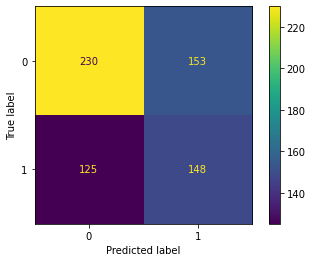

In [101]:
SVM_PARAMS = {
        'classifier__kernel': ["rbf"],
        'classifier__gamma': [10 ** (5 - i) for i in range(10)],
        'classifier__C': [10 ** (4 - i) for i in range(10)]
}

svm_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('smote', SMOTE()),
    ("preprocessing", StandardScaler()),
    ("classifier", SVC(C=10, gamma=0.1))
])

svm_grid = fit_and_test_grid(svm_pipe, SVM_PARAMS, keep_nan=False, verbose=0) # only train nan are deleted

SVC achieves good results when using a rbf kernel (linear and polynomial results were deleted from the code above).

# Naive Bayes

Since we have indenpendance (very low correlation) between features, neive bayes can be an interesting option. Another advantage of this method is that it requires few training data and is fast.

Precision:  0.48
Recall:  0.45
F1-score:  0.47
Best parameters:  Pipeline(steps=[('imputer', SimpleImputer()), ('smote', SMOTE()),
                ('preprocessing', None), ('classifier', GaussianNB())])


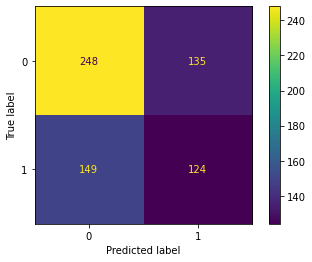

In [103]:
BAYES_PARAMS = {
    'preprocessing': [None, StandardScaler(), MinMaxScaler()]
}

bayes_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('smote', SMOTE()),
    ("preprocessing", StandardScaler()),
    ("classifier", GaussianNB())
])

bayes_grid = fit_and_test_grid(bayes_pipe, BAYES_PARAMS, keep_nan=False, verbose=0)

# NN


Precision:  0.47
Recall:  0.45
F1-score:  0.46
Best parameters:  Pipeline(steps=[('imputer', SimpleImputer()), ('smote', SMOTE()),
                ('preprocessing', None), ('classifier', GaussianNB())])


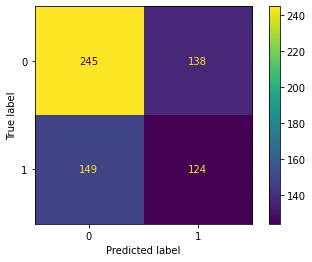

In [104]:
MLP_PARAMS = {
    'preprocessing': [None, StandardScaler(), MinMaxScaler()]
}

MLP_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('smote', SMOTE()),
    ("preprocessing", StandardScaler()),
    ("classifier", GaussianNB())
])

MLP_grid = fit_and_test_grid(MLP_pipe, MLP_PARAMS, keep_nan=False, verbose=0)

# Ensemble techniques

We are now trying to combine different individual models to improve model flexibility and data-sensivity. We'll try the two types of methods seen during the course, i.e. Bagging and Boosting.

## Bagging

We train in parallel a bunch of models on a random subset of data.

In [ ]:
FOREST_PARAMS = {
    'classifier__max_depth': [i for i in range(3, 30, 3)],
    'classifier__min_samples_leaf': [i for i in range(3, 30, 3)],
    'classifier__max_features': ['auto'],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__class_weight': ['balanced', 'balanced_subsample'],
    'classifier__n_estimators': [10, 50, 100, 150]
}


# Decision trees don't need standard scaling
forest_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ("classifier", RandomForestClassifier())
])

forest_grid = fit_and_test_grid(forest_pipe, FOREST_PARAMS, keep_nan=True, verbose=0)

## Boosting

Boosting consists in training a bunch of models in a sequetial way. Each individual model learns from mistakes made by the previous.

## Bagging + Boosting

Here we tried to mix both approaches. 

Precision:  0.71
Recall:  0.08
F1-score:  0.14
Best parameters:  Pipeline(steps=[('imputer', SimpleImputer()), ('scale', StandardScaler()),
                ('AB',
                 AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=5,
                                                                          min_samples_leaf=10,
                                                                          random_state=42),
                                    learning_rate=0.01, n_estimators=5,
                                    random_state=42))])


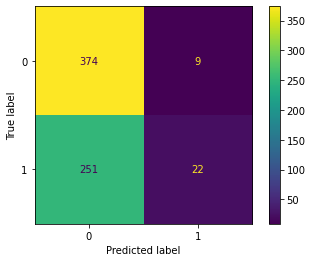

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scale', StandardScaler()),
                                       ('AB',
                                        AdaBoostClassifier(base_estimator=RandomForestClassifier(max_depth=5,
                                                                                                 min_samples_leaf=10,
                                                                                                 random_state=42),
                                                           learning_rate=0.01,
                                                           n_estimators=5,
                                                           random_state=42))]),
             param_grid={}, scoring=make_scorer(f1_score))

In [94]:
RFBE = RandomForestClassifier(random_state=42,bootstrap=True,criterion='gini',max_depth=5,min_samples_leaf=10)
AdaBoost_Pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scale',StandardScaler()),
    ('classifier', AdaBoostClassifier(random_state = 42,
        base_estimator = RFBE,
        learning_rate=0.01,
        n_estimators=5))])

fit_and_test_grid(AdaBoost_Pipeline, {})

## LGBMC classifier

LightGBM is a gradient boosting framework that uses tree based learning algorithms.

Precision:  0.52
Recall:  0.54
F1-score:  0.53
Best parameters:  Pipeline(steps=[('imputer', SimpleImputer()), ('smote', SMOTE(random_state=42)),
                ('scale', StandardScaler()),
                ('classifier', LGBMClassifier(n_estimators=98))])


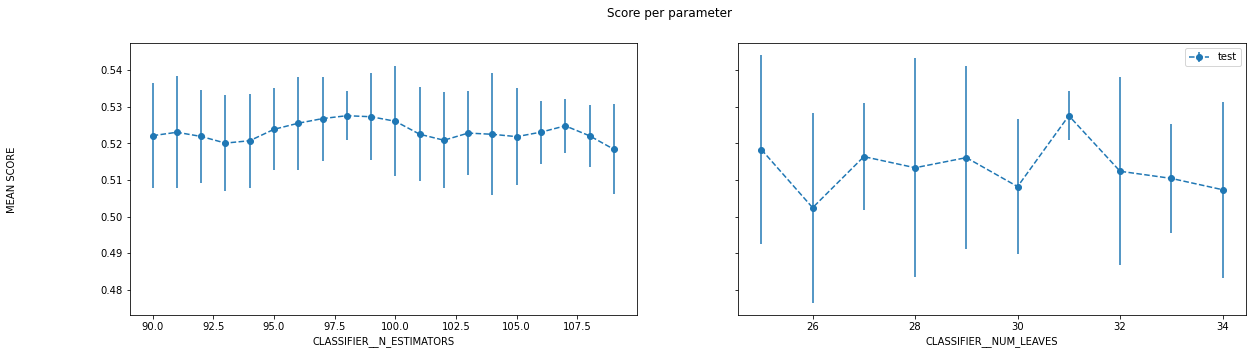

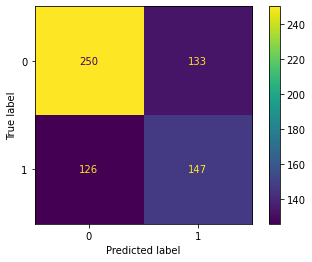

In [91]:

lgbmc_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('smote', SMOTE(random_state=42)),
    ('scale', StandardScaler()),
    ('classifier', LGBMClassifier())
])

params = {
    'classifier__n_estimators': np.arange(90, 110),
    'classifier__num_leaves': np.arange(25, 35)
}

lgmbc_grid = fit_and_test_grid(
    lgbmc_pipe, 
    params,
    keep_nan=True,
    verbose=0,
    smote=False
)